https://www.kaggle.com/code/voltvipin/birdclassification-using-pytorch/notebook



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models

In [2]:
# Get the available device

if torch.cuda.is_available():
    dev = "cuda:0"  # Gpu
else:
    dev = "cpu"
device = torch.device(dev)

/home/yaxin/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# dataset & dataloader
train / test : caries/crown/filling

In [3]:
IMG_SIZE = 224
transform = transforms.Compose([
    # transforms.RandomCrop(500),
    # transforms.Resize((IMG_SIZE, IMG_SIZE )),    
    # transforms.RandomRotation(180),
    # transforms.ToTensor(), # it does transforms.Normalize(0., 255.) also
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset = torchvision.datasets.ImageFolder(root="/home/yaxin/caries/all/train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(root="/home/yaxin/caries/all/test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=False)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(trainset),
    "test": len(testset)
}
# CLASSES = list(trainset.class_to_idx.keys())

In [5]:
CLASSES

['caries', 'crown', 'filling']

In [4]:
def imshow(img, size=(10, 10)):
    # img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

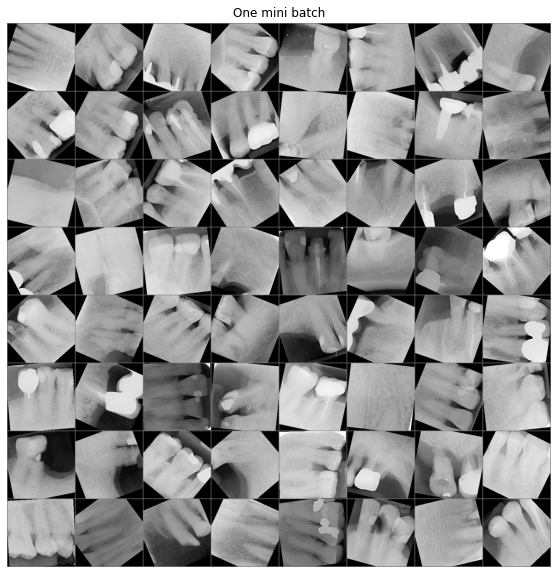

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# imshow(torchvision.utils.make_grid(images))

# model

# model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [33]:
train_losses = []
test_losses =[]
train_accs = []
test_accs = []

def train_model(model, criterion, optimizer, scheduler, epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs))
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parametsrs
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / datasizes[phase]
            if phase == "train":
                train_losses.append(epoch_loss)
            epoch_acc = running_corrects.double()/datasizes[phase]
            if phase == "test":
                test_accs.append(epoch_acc)

            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            if(phase == "test" and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f".format(best_acc))
    
    # load best model parameters
    model.load_state_dict(best_model_wts)
    return model

In [16]:
pip install --upgrade ipywidgets

  Using cached ipywidgets-7.7.1-py2.py3-none-any.whl (123 kB)
  Using cached widgetsnbextension-3.6.1-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyterlab_widgets-1.1.1-py3-none-any.whl (245 kB)
Note: you may need to restart the kernel to use updated packages.


In [32]:
test_accs

[tensor(0.3333, dtype=torch.float64), tensor(0.4667, dtype=torch.float64)]

In [11]:
model_ft = models.resnet18(pretrained=True)

# turn training false for all layers, other than fc layer
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(CLASSES))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)
exp_lr_sc = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yaxin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [19]:
pip install tqdm==4.40.0

     |████████████████████████████████| 54 kB 1.1 MB/s eta 0:00:011
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_sc, epochs=200)

Epoch 0/200
----------
train Loss: 0.8914 Acc: 0.5902
test Loss: 0.9627 Acc: 0.5333

Epoch 1/200
----------
train Loss: 0.8820 Acc: 0.6165
test Loss: 1.0851 Acc: 0.3333

Epoch 2/200
----------
train Loss: 0.8665 Acc: 0.6128
test Loss: 1.0696 Acc: 0.2667

Epoch 3/200
----------
train Loss: 0.9187 Acc: 0.5602
test Loss: 0.9158 Acc: 0.4667

Epoch 4/200
----------
train Loss: 0.8685 Acc: 0.6278
test Loss: 0.9744 Acc: 0.5333

Epoch 5/200
----------
train Loss: 0.8651 Acc: 0.6391
test Loss: 0.9305 Acc: 0.4667

Epoch 6/200
----------
train Loss: 0.8891 Acc: 0.5977
test Loss: 0.9357 Acc: 0.6000

Epoch 7/200
----------
train Loss: 0.8781 Acc: 0.6278
test Loss: 1.1255 Acc: 0.4000

Epoch 8/200
----------
train Loss: 0.8734 Acc: 0.5940
test Loss: 1.0654 Acc: 0.4000

Epoch 9/200
----------
train Loss: 0.8910 Acc: 0.5902
test Loss: 1.1664 Acc: 0.4000

Epoch 10/200
----------
train Loss: 0.8783 Acc: 0.5902
test Loss: 1.1415 Acc: 0.3333

Epoch 11/200
----------
train Loss: 0.9172 Acc: 0.5602
test Loss

Text(0.5, 1.0, 'test_accs')

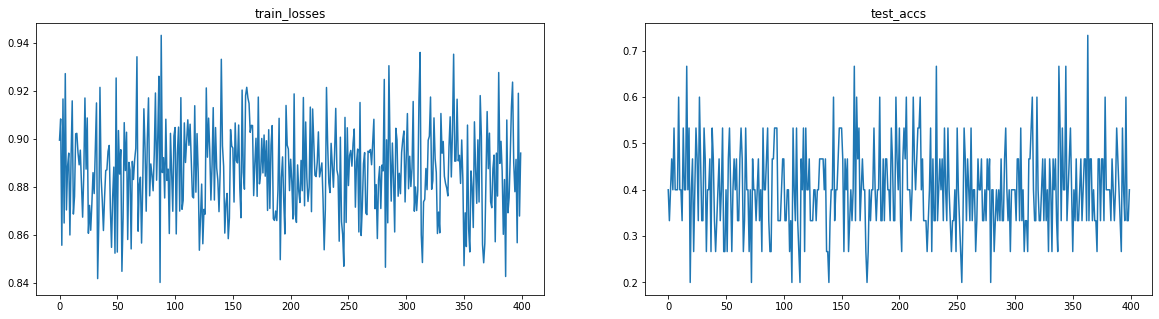

In [36]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(train_losses)
axes[0].set_title("train_losses")
axes[1].plot(test_accs)
axes[1].set_title("test_accs")

In [37]:
FILE = '/home/yaxin/caries/class/model/resnet18_200.pt'
torch.save({
                'epoch': 200,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, FILE)

 # Predict

In [46]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=15):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(3, 5, figsize=(20, 20))
    
    
    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            # print(inputs)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)


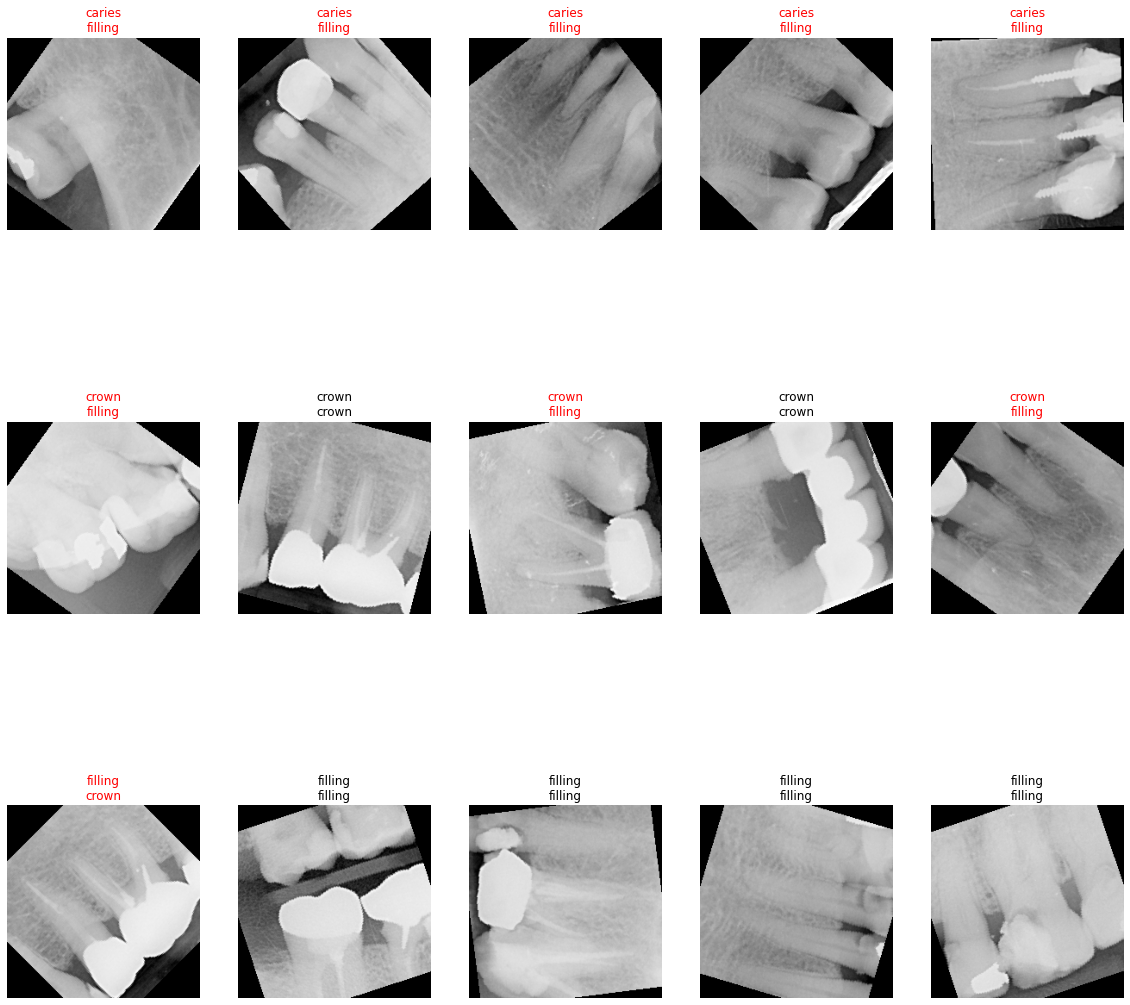

In [47]:
# Title: Original vs Predicted 
vis_model(model_ft)